In [1]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from sklearn import linear_model, tree, ensemble
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

/Users/itayreznik/opt/anaconda3/envs/aml22/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Data Analysis

In [21]:
ds = pd.read_pickle('data/ass3.pickle')
train, dev = ds['train'], ds['dev']
train_features, train_targets = train
dev_features, dev_targets = dev

In [4]:
def analyze_data(features, targets):
    feature_names = [f'f{i}' for i in range(features.shape[-1])]
    print(f'number of samples: {features.shape[0]}')
    print(f'number of features: {features.shape[-1]}')
    print(f'feature names: \n  {feature_names}')
    print(f"range of target: max:{targets.max()} , min:{targets.min()}")
    # classes = set(targets.values)
    # print(f"classes: \n  {classes}")
    print(f'number of samples per class:')
    # for class_name in classes:
    # print(f"  {class_name} {len(features[targets==class_name])}")
    ranges_for_features = list(zip(feature_names, features.min(axis=0), features.max(axis=0)))
    print(f'ranges of features:')
    for index, (name, min_val, max_val) in enumerate(ranges_for_features):
        print(f'  {name} {min_val} - {max_val}\t dtype: {features[index].dtype}')

    print(f'mean: \n{features.mean()}')
    print(f'variance: \n{features.var()}')

#### Perliminary analysis: train

In [6]:
analyze_data(train_features, train_targets)

number of samples: 48226
number of features: 13
feature names: 
  ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12']
range of target: max:39.58888888888889 , min:-21.822222222222226
number of samples per class:
ranges of features:
  f0 0.0 - 26.0	 dtype: float64
  f1 -1.0 - 1.0	 dtype: float64
  f2 0.0 - 1.0	 dtype: float64
  f3 0.0 - 55.9314	 dtype: float64
  f4 0.0 - 359.0	 dtype: float64
  f5 0.0 - 16.1	 dtype: float64
  f6 0.0 - 0.0	 dtype: float64
  f7 0.0 - 1046.26	 dtype: float64
  f8 0.0 - 213.0	 dtype: float64
  f9 1.0 - 31.0	 dtype: float64
  f10 1.0 - 12.0	 dtype: float64
  f11 2006.0 - 2016.0	 dtype: float64
  f12 0.0 - 23.0	 dtype: float64
mean: 
261.7853131566439
variance: 
326289.30631842325


#### Perliminary analysis: dev

In [7]:
analyze_data(dev_features, dev_targets)

number of samples: 24114
number of features: 13
feature names: 
  ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12']
range of target: max:38.84444444444445 , min:-20.555555555555557
number of samples per class:
ranges of features:
  f0 0.0 - 26.0	 dtype: float64
  f1 -1.0 - 1.0	 dtype: float64
  f2 0.0 - 1.0	 dtype: float64
  f3 0.0 - 63.8526	 dtype: float64
  f4 0.0 - 359.0	 dtype: float64
  f5 0.0 - 16.1	 dtype: float64
  f6 0.0 - 0.0	 dtype: float64
  f7 0.0 - 1045.93	 dtype: float64
  f8 0.0 - 213.0	 dtype: float64
  f9 1.0 - 31.0	 dtype: float64
  f10 1.0 - 12.0	 dtype: float64
  f11 2006.0 - 2016.0	 dtype: float64
  f12 0.0 - 23.0	 dtype: float64
mean: 
261.5990626240103
variance: 
326194.50242981524


#### Data Pre-processing and more analysis

After analysis, we observe that the data is composed of real numbers, which suggests that the data points are drawn from a continuous distribution. This tells us that we are trying to solve a regression problem, which does not immediately make us think of a specific model that would work.

Nevertheless, we will try to normalize the data and see if it improves the results.

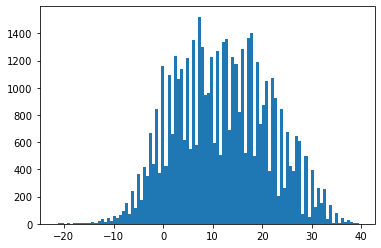

In [8]:
plt.hist(train_targets, bins=100)
plt.show()

In [9]:
scaler = StandardScaler()
normalized_train_features = scaler.fit_transform(train_features)
normalized_dev_features = scaler.transform(dev_features)

We can perform PCA on the data and normalized data to analyze the separability of the main features.

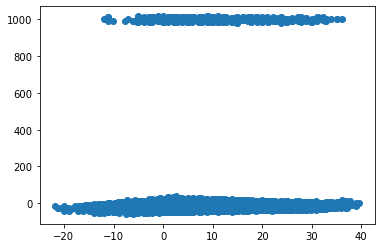

<Figure size 600x600 with 0 Axes>

In [10]:
pca = PCA(n_components=1)
trans_train_features = pca.fit_transform(train_features)
plt.scatter(train_targets, *zip(*trans_train_features), cmap='Set2')
plt.figure(figsize=(6, 6), dpi=100)
plt.show()

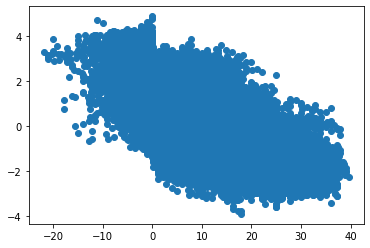

<Figure size 600x600 with 0 Axes>

In [11]:
pca = PCA(n_components=1)
trans_train_features = pca.fit_transform(normalized_train_features)
plt.scatter(train_targets, *zip(*trans_train_features), cmap='Set2')
plt.figure(figsize=(6, 6), dpi=100)
plt.show()

The data does not seem very separable, so we assume that the more naive models will fail, or at least will not do very well.

## Experiments

In the context of regression, there are many ways to measure the success of the model on the data, for example MAE, MSE and R2 scores. We choose the MAE score as it is more commonly used than R2 and a bit more robust than MSE.

In [12]:
def mae_score(model, features, targets):
    preds = model.predict(features)
    return np.mean(np.abs(preds - targets))


We wanted to play around with scaling.
So we trained a MinMaxScaler (which range is [0,1] or [-1,1] if there are negative values in the data) on the train target. Then we wrote another mae score function that gives us the mean absolute error that we would get, if our data was in the range of [-1,1].

At the end of this document, we will calculate the error of our final model with this function also. 

In [50]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_targets[:,None],y=None)

def mae_score_normalized(model, features, targets):
    preds = model.predict(features)
    target_normalized = scaler.transform(targets[:,None])
    predicted_normalized = scaler.transform(preds[:,None])
    return np.mean(np.abs(predicted_normalized - target_normalized))




In [52]:
print(train_targets.shape)

(48226,)


#### Basic model: Linear Regression
Before we advance to more complicated models, let us first experiment on a basic models and see the results. In this case, the simplest basic model we can try is Linear Regression.

In [14]:
lin_reg = linear_model.LinearRegression()
lin_reg.fit(train_features, train_targets)
mae_score(lin_reg, dev_features, dev_targets)

4.785717287736162

Since MAE (similar to other regression scores) does not have a meaning to us in the same sense that percentage does, we have to compare to other models in order to see how well our model did. Still, we expect more complicated models to work better Linear Regression.

#### Decision Tree
Now we want to try the more complicated models. We will start with a simple Decision Tree and test it's results out of the box. Then we will do some cross validation to try and tune the hyperparameters.

In [15]:
decision_tree = tree.DecisionTreeRegressor(random_state=42)
decision_tree.fit(train_features, train_targets)
mae_score(decision_tree, dev_features, dev_targets)

1.846204371826417

Out of the box, the Decision Tree works better than the basic model, much better. We can try feature selection and cross validation to get better results. First we try feature selection alone, then we try it with cross validaton.

In [16]:
parameters = {
    'max_depth': [5, 10, 20, 30, 50],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
}

dt = tree.DecisionTreeRegressor(random_state=42)

clf = GridSearchCV(dt, parameters)
clf.fit(train_features, train_targets)
mae_score(clf, dev_features, dev_targets)

1.8565658798824305

We could not find better parameters with our grid search and cross validation, in fact results are worse, but not much worse. This suggests that the model is quite robust to different hyperparmeteres, but maybe we can do better with other models.

#### Random Forest
The Decision tree works better than the simple models, which aligns with our initial thoughts. This bares the question, would a random forest do better? If so, how much better and for what cost of training time.

In [49]:
random_forest = ensemble.RandomForestRegressor(n_estimators=100, random_state=42)

random_forest.fit(train_features, train_targets)
mae_score(random_forest, dev_features, dev_targets)

1.4047712785564863

Again, out of the box results are better than previous model, but training time is very long, so we might prefer other models that work faster.

Still, we should try cross validation to improve the Random Forest and see what is our current best score, to be beaten by the following models.

In [50]:
parameters = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
}

rf = ensemble.RandomForestRegressor(random_state=42)

clf = GridSearchCV(rf, parameters)
clf.fit(train_features, train_targets)
mae_score(clf, dev_features, dev_targets)

1.4186451152726691

#### Adaptive Boosting with Random Forest

Using cross validation did not improve the model, but we have a current baseline to try and improve on. We can try Adaptive Boosting to improve on it.

In [17]:
ada_boost = ensemble.AdaBoostRegressor(random_state=42, learning_rate=0.2)

ada_boost.fit(train_features, train_targets)
mae_score(ada_boost, dev_features, dev_targets)

3.538248101408444

Immediately we see that the AdaBoost results are poor in comparison to the regular Random Forest. We can try some cross validation, but we don't expect it to improve the results to the point of beating the Random Forest baseline.

In [25]:
parameters = {
    'n_estimators': [50, 70, 100],
    'learning_rate': [0.01, 0.1, 0.2]
}

best_ab = None
best_score = 0.
best_params = ()

ab = ensemble.AdaBoostRegressor(random_state=42)

clf = GridSearchCV(ab, parameters)
clf.fit(train_features, train_targets)
mae_score(clf, dev_features, dev_targets)

3.4127513169545263

The results are a bit better, but still much worse than the Random Forest, as we expected.

#### Gradient Boosting

Adaptive boosting worked poorly on this dataset, but we can still try Gradient Boosting to see how well it does. We try the default params and then cross validation to get the best model.

In [24]:
gb = ensemble.GradientBoostingRegressor()
gb.fit(train_features, train_targets)
mae_score(gb, dev_features, dev_targets)

2.3944055837685854

In [ ]:
parameters = {
    'n_estimators': [100],
    'learning_rate': [0.1, 0.11, 0.09],
    'max_depth': [100],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

gb = ensemble.GradientBoostingRegressor(random_state=42)

clf = GridSearchCV(gb, parameters)
clf.fit(train_features, train_targets)
mae_score(clf, dev_features, dev_targets)

The results of Gradient boosting are better than AdaBoost, but still worse than random forest. Cross validation improved on them, but not enough to beat the baseline.

#### XGBoost

XGBoost is known to produce state-of-the-art results on a variety of datasets. Thus, we wish to assess its effectiveness on our dataset, again first on default params.

In [28]:
xgb = XGBRegressor()
xgb.fit(train_features, train_targets)
mae_score(xgb, dev_features, dev_targets)

1.6626661964272615

Immediately, the results look close to comparable with the baseline, and we know that XGBoost is sensitive to hyperparameters, which it has quite a few of.

Since there are many hyperparmeters to select, we try a different method of checking. We use the package Optuna to find the best combination of hyperparameters for XGBoost.

In [31]:
def objective(trial):
    train_x, train_y, valid_x, valid_y = train_features, train_targets, dev_features, dev_targets
    param = {
        "verbosity": 0,
        # # defines booster, gblinear for linear functions.
        "booster": 'gbtree',
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        # "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # # sampling ratio for training data.
        # "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        # "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 29, step=1)
        # # minimum child weight, larger the term more conservative the tree.
        # param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 19)
        # param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1, 10.0, log=True)
        # param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    # if param["booster"] == "dart":
    #     param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
    #     param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
    #     param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
    #     param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    xgb = XGBRegressor(**param)
    xgb.fit(train_x, train_y)
    accuracy = mae_score(xgb, dev_features, dev_targets)
    return accuracy

In [33]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-06-29 17:26:30,856] A new study created in memory with name: no-name-2343af0e-160f-41e2-912a-611253299aa1
[I 2022-06-29 17:26:37,369] Trial 0 finished with value: 1.2167576615399744 and parameters: {'lambda': 0.0001429443001903382, 'learning_rate': 0.13098938017365075, 'max_depth': 13, 'gamma': 1.193194656320468}. Best is trial 0 with value: 1.2167576615399744.
[I 2022-06-29 17:26:44,005] Trial 1 finished with value: 1.2717908238274127 and parameters: {'lambda': 2.570882677012224e-07, 'learning_rate': 0.19428726921362308, 'max_depth': 14, 'gamma': 3.1887936586378394}. Best is trial 0 with value: 1.2167576615399744.
[I 2022-06-29 17:26:52,009] Trial 2 finished with value: 1.241437341377925 and parameters: {'lambda': 0.14808026837669389, 'learning_rate': 0.12684666779366738, 'max_depth': 15, 'gamma': 2.5440393974745423}. Best is trial 0 with value: 1.2167576615399744.
[I 2022-06-29 17:26:53,616] Trial 3 finished with value: 1.960102873107053 and parameters: {'lambda': 0.436510937

Number of finished trials:  59
Best trial:
  Value: 1.1758238181022274
  Params: 
    lambda: 0.02202645400480881
    learning_rate: 0.15980545084240536
    max_depth: 11
    gamma: 1.091827352641474


#### Final model
As we can see, the XGBoost model with the parameters searched with optuna gave us the best results, and it also runs much faster than the Random Forest model fitting. We see this as an absolute win.

In [35]:
parameters = {
    'lambda': 0.02202645400480881,
    'learning_rate': 0.15980545084240536,
    'max_depth': 11,
    'gamma': 1.091827352641474,
}
xgb = XGBRegressor(**parameters)
xgb.fit(train_features, train_targets)
mae_score(xgb, dev_features, dev_targets)

1.1758238181022274

Here we calculate the mean absolute error of our final model, as if the data range was [-1,1]:

In [51]:
parameters = {
    'lambda': 0.02202645400480881,
    'learning_rate': 0.15980545084240536,
    'max_depth': 11,
    'gamma': 1.091827352641474,
}
xgb = XGBRegressor(**parameters)
xgb.fit(train_features, train_targets)
mae_score_normalized(xgb, dev_features, dev_targets)






0.01914676017221333